# Predict Beeth Music

In [1]:
!pip install torch torchvision torchaudio
!pip install pretty_midi tqdm

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.21.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_nvjitlink_cu1

## Imports 

In [ ]:
# Standard library imports
import os
import sys
import time
from typing import Optional, Tuple

# Third-party imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.autograd import Variable
import pretty_midi
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns


# Local imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# import from utils
from src.utils.utils import(
    load_midi_data, load_all_midi_files, progress_bar, logger, format_time,
    rand_slice, seq_to_tensor, train_slice, train_batch, song_to_seq_target,
    save_checkpoint, load_checkpoint
)


ModuleNotFoundError: No module named 'src'

In [ ]:
def load_midi_data(file_path: str) -> Optional[np.ndarray]:
    """
    Carga un archivo MIDI y extrae las características de las notas.

    Args:
      file_path: Ruta al archivo MIDI.

    Returns:
      Un array NumPy con las características de las notas o None si hay un error.
    """
    try:
        midi_data = pretty_midi.PrettyMIDI(file_path)
        instrument = midi_data.instruments[0]  # Seleccionar el primer instrumento
        notes = instrument.notes
        features = []
        prev_start = 0.0

        for note in notes:
            pitch = note.pitch
            start = note.start
            end = note.end
            step = start - prev_start  # Tiempo desde la nota anterior
            duration = end - start
            velocity = note.velocity
            features.append([pitch, step, duration, velocity])
            prev_start = start

        return np.array(features)
    except Exception as e:
        print(f"Error al cargar {file_path}: {e}")
        return None

def load_all_midi_files(midi_dir_path: str) -> Optional[np.ndarray]:
    """
    Carga todos los archivos MIDI en un directorio.

    Args:
      midi_dir_path: Ruta al directorio que contiene los archivos MIDI.

    Returns:
      Un array NumPy con las características de todas las notas o None si hay un error.
    """
    if not os.path.exists(midi_dir_path):
        print(f"El directorio no existe: {midi_dir_path}")
        return None

    midi_files = [f for f in os.listdir(midi_dir_path) if f.endswith('.mid')]
    all_music_data = []

    for midi_file in tqdm(midi_files, desc="Cargando archivos MIDI"):
        midi_file_path = os.path.join(midi_dir_path, midi_file)
        music_data = load_midi_data(midi_file_path)
        if music_data is not None:
            all_music_data.append(music_data)

    return np.concatenate(all_music_data, axis=0) if all_music_data else None

# Datos musicales

Se escogen datos correspondientes al compositor Beethoven. A continuación se gráfican las distribuciones de los mismos para decidir cómo tratarlos

Cargando datos MIDI...


Cargando archivos MIDI: 100%|██████████| 29/29 [00:05<00:00,  5.05it/s]


Distribuciones originales y normalizadas individualmente (Min-Max):


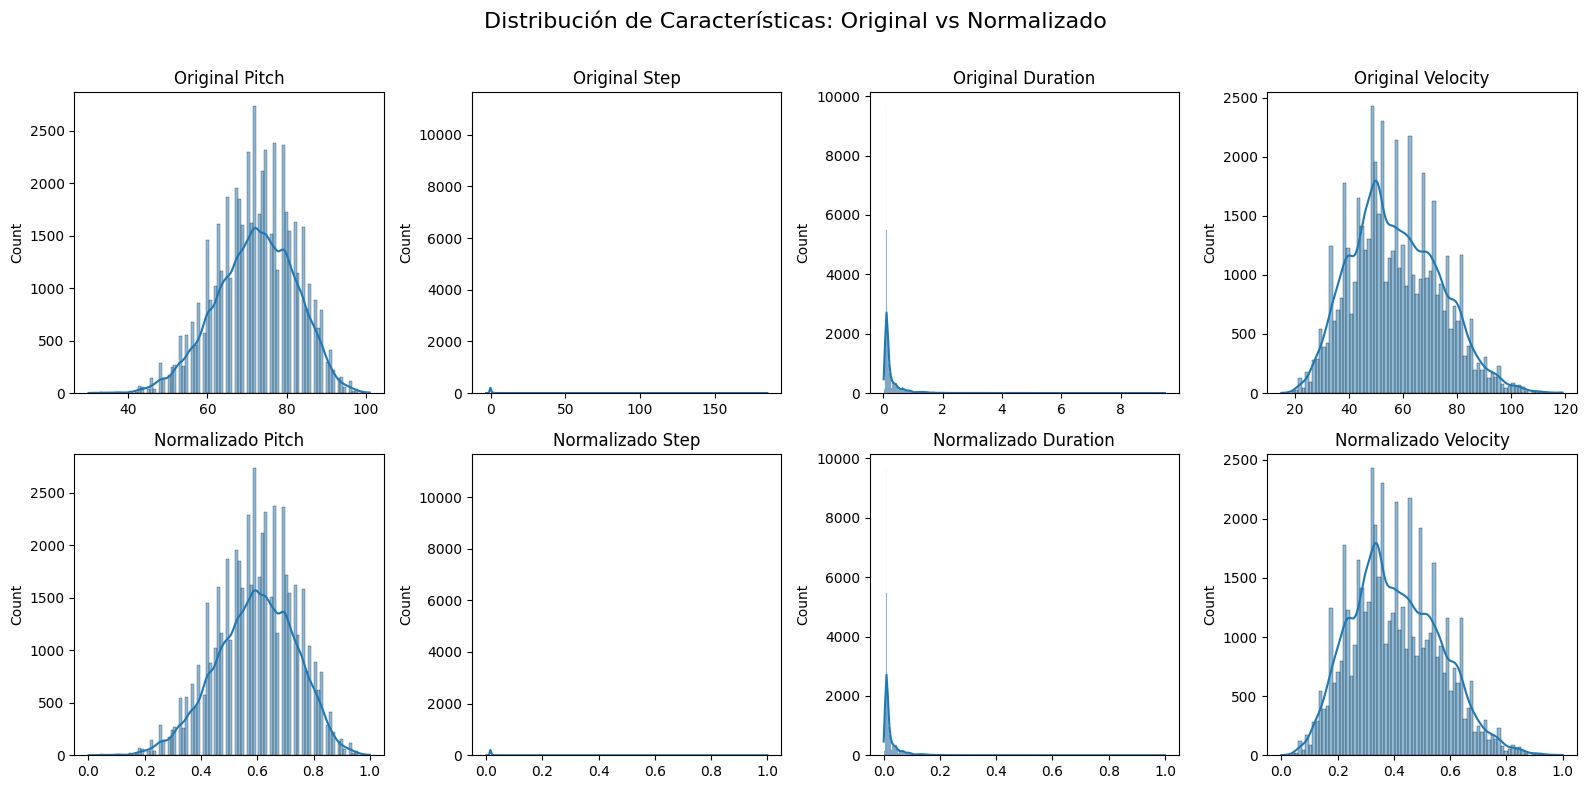

Distribuciones originales y normalizadas individualmente (Z-Score):


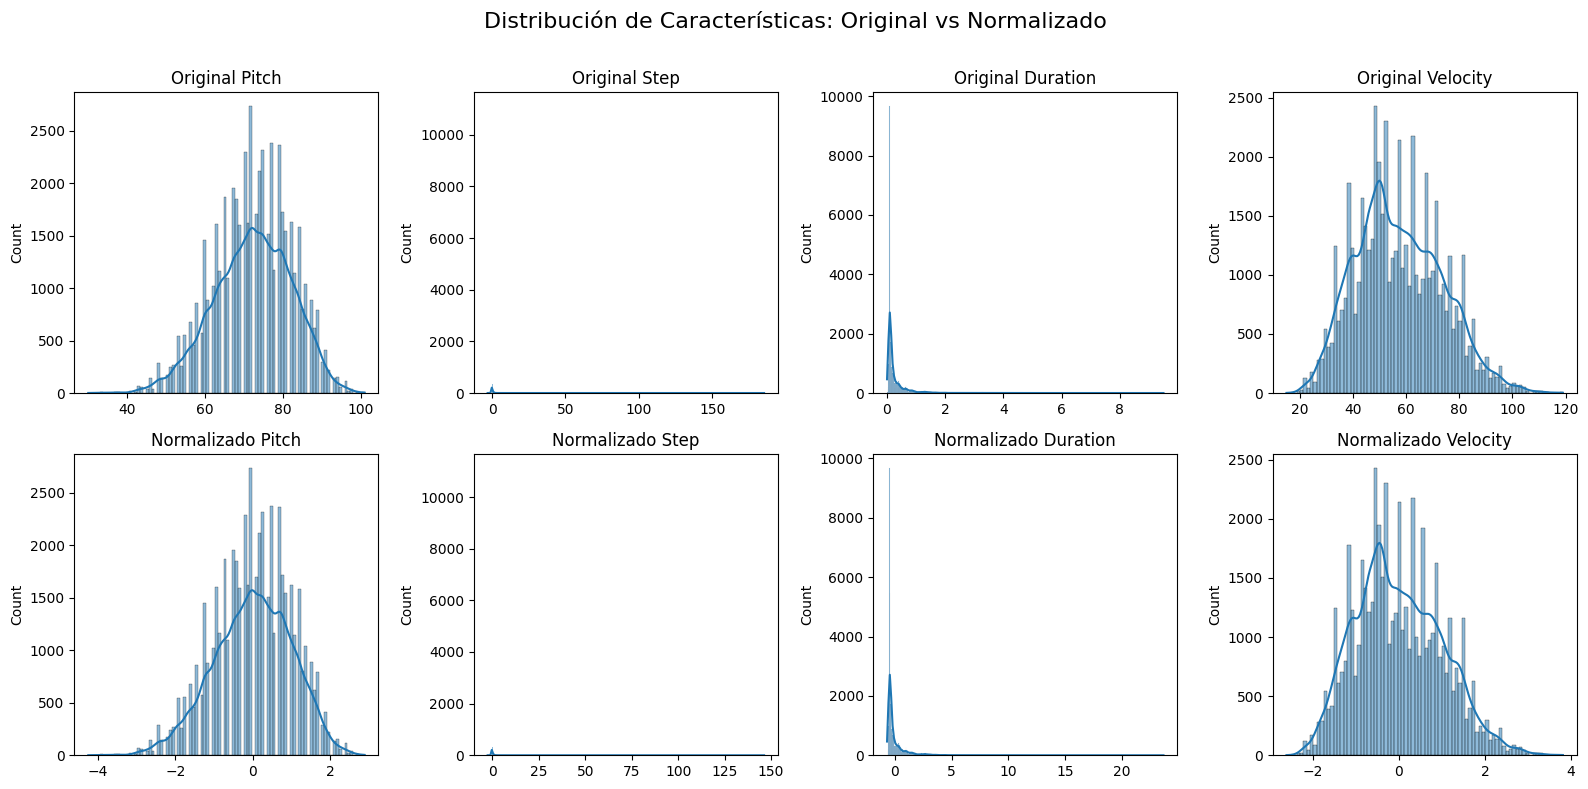

In [3]:
def plot_feature_distributions(data: np.ndarray, normalized_data: np.ndarray):
    """
    Grafica las distribuciones de los datos originales y normalizados.

    Args:
      data: Datos originales.
      normalized_data: Datos normalizados.
    """
    feature_names = ['Pitch', 'Step', 'Duration', 'Velocity']
    fig, axes = plt.subplots(2, len(feature_names), figsize=(16, 8))
    fig.suptitle('Distribución de Características: Original vs Normalizado', fontsize=16)

    for i, feature in enumerate(feature_names):
        sns.histplot(data[:, i], kde=True, ax=axes[0][i])
        axes[0][i].set_title(f'Original {feature}')
        sns.histplot(normalized_data[:, i], kde=True, ax=axes[1][i])
        axes[1][i].set_title(f'Normalizado {feature}')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def min_max_normalize_data_separately(data: np.ndarray) -> np.ndarray:
    """
    Normaliza cada característica individualmente utilizando la técnica Min-Max.

    Args:
      data: Array NumPy con los datos.

    Returns:
      Array NumPy con los datos normalizados característica por característica.
    """
    data_min = data.min(axis=0, keepdims=True)
    data_max = data.max(axis=0, keepdims=True)
    return (data - data_min) / (data_max - data_min + 1e-6)

def z_score_normalize_data_separately(data: np.ndarray) -> np.ndarray:
    """
    Estandariza cada característica individualmente utilizando el método Z-Score.

    Args:
      data: Array NumPy con los datos.

    Returns:
      Array NumPy con los datos estandarizados característica por característica.
    """
    mean = data.mean(axis=0, keepdims=True)
    std = data.std(axis=0, keepdims=True)
    return (data - mean) / (std + 1e-6)

print("Cargando datos MIDI...")
all_music_data = load_all_midi_files('beeth')

# Normalizar las características individualmente usando Min-Max
normalized_data_minmax_individual = min_max_normalize_data_separately(all_music_data)

# Normalizar las características individualmente usando Z-Score
normalized_data_zscore_individual = z_score_normalize_data_separately(all_music_data)

print("Distribuciones originales y normalizadas individualmente (Min-Max):")
plot_feature_distributions(all_music_data, normalized_data_minmax_individual)

print("Distribuciones originales y normalizadas individualmente (Z-Score):")
plot_feature_distributions(all_music_data, normalized_data_zscore_individual)

In [4]:
def print_statistics(data: np.ndarray, label: str):
    """
    Imprime el rango, media, y desviación estándar para cada característica en los datos.

    Args:
      data: Array NumPy con los datos.
      label: Etiqueta para identificar el conjunto de datos.
    """
    print(f"Estadísticas para {label}:")
    feature_names = ['Pitch', 'Step', 'Duration', 'Velocity']

    for i, feature in enumerate(feature_names):
        feature_data = data[:, i]
        print(f"{feature}: Rango [{feature_data.min():.2f}, {feature_data.max():.2f}], "
              f"Media: {feature_data.mean():.2f}, "
              f"Desviación Estándar: {feature_data.std():.2f}")
    print('\n')

# Estadísticas antes de la normalización
print_statistics(all_music_data, "Datos Originales")

# Estadísticas después de normalización Min-Max
print_statistics(normalized_data_minmax_individual, "Datos Normalizados (Min-Max)")

# Estadísticas después de estandarización Z-Score
print_statistics(normalized_data_zscore_individual, "Datos Estandarizados (Z-Score)")

Estadísticas para Datos Originales:
Pitch: Rango [30.00, 101.00], Media: 72.28, Desviación Estándar: 9.96
Step: Rango [-3.03, 185.37], Media: 0.20, Desviación Estándar: 1.27
Duration: Rango [0.01, 9.50], Media: 0.28, Desviación Estándar: 0.39
Velocity: Rango [15.00, 119.00], Media: 57.32, Desviación Estándar: 16.17


Estadísticas para Datos Normalizados (Min-Max):
Pitch: Rango [0.00, 1.00], Media: 0.60, Desviación Estándar: 0.14
Step: Rango [0.00, 1.00], Media: 0.02, Desviación Estándar: 0.01
Duration: Rango [0.00, 1.00], Media: 0.03, Desviación Estándar: 0.04
Velocity: Rango [0.00, 1.00], Media: 0.41, Desviación Estándar: 0.16


Estadísticas para Datos Estandarizados (Z-Score):
Pitch: Rango [-4.25, 2.88], Media: -0.00, Desviación Estándar: 1.00
Step: Rango [-2.55, 146.21], Media: 0.00, Desviación Estándar: 1.00
Duration: Rango [-0.69, 23.70], Media: -0.00, Desviación Estándar: 1.00
Velocity: Rango [-2.62, 3.81], Media: 0.00, Desviación Estándar: 1.00




## Sobre outliers

Los datos originales de Step estás demasiado espaciados con una desvación estándar pequeña, lo que me sugiere outliers y por tanto se van a filtrar

In [23]:
def filter_outliers(data: np.ndarray, lower_percentile: float = 5, upper_percentile: float = 95) -> np.ndarray:
    """
    Filtra los outliers basados en percentiles para todas las características simultáneamente.

    Args:
      data: Array NumPy con los datos.
      lower_percentile: Percentil inferior para la filtración.
      upper_percentile: Percentil superior para la filtración.

    Returns:
      Datos filtrados sin outliers.
    """
    mask = np.ones(data.shape[0], dtype=bool)
    for col in range(data.shape[1]):
        lower_bound = np.percentile(data[:, col], lower_percentile)
        upper_bound = np.percentile(data[:, col], upper_percentile)
        col_mask = (data[:, col] >= lower_bound) & (data[:, col] <= upper_bound)
        mask &= col_mask
    return data[mask]

In [26]:
# Corrección del procedimiento
print("Cargando datos MIDI...")
all_music_data = load_all_midi_files('beeth')

# Filtrar outliers
filtered_music_data = filter_outliers(all_music_data, 1, 99)

# Normalizar las características individualmente usando Min-Max en datos filtrados
normalized_data_minmax_individual_filtrado = min_max_normalize_data_separately(filtered_music_data)

# Normalizar las características individualmente usando Z-Score en datos filtrados
normalized_data_zscore_individual_filtrado = z_score_normalize_data_separately(filtered_music_data)

# Estadísticas de datos originales antes de filtrado
print_statistics(all_music_data, "Datos Originales")

# Estadísticas de datos filtrados
print_statistics(filtered_music_data, "Datos Filtrados")

# Estadísticas después de normalización Min-Max
print_statistics(normalized_data_minmax_individual_filtrado, "Datos Filtrados y Normalizados (Min-Max)")

# Estadísticas después de estandarización Z-Score
print_statistics(normalized_data_zscore_individual_filtrado, "Datos Filtrados y Estandarizados (Z-Score)")

Cargando datos MIDI...


Cargando archivos MIDI: 100%|██████████| 29/29 [00:04<00:00,  6.35it/s]

Estadísticas para Datos Originales:
Pitch: Rango [30.00, 101.00], Media: 72.28, Desviación Estándar: 9.96
Step: Rango [-3.03, 185.37], Media: 0.20, Desviación Estándar: 1.27
Duration: Rango [0.01, 9.50], Media: 0.28, Desviación Estándar: 0.39
Velocity: Rango [15.00, 119.00], Media: 57.32, Desviación Estándar: 16.17


Estadísticas para Datos Filtrados:
Pitch: Rango [48.00, 93.00], Media: 72.38, Desviación Estándar: 9.41
Step: Rango [-0.47, 1.76], Media: 0.18, Desviación Estándar: 0.26
Duration: Rango [0.05, 1.91], Media: 0.24, Desviación Estándar: 0.27
Velocity: Rango [27.00, 96.00], Media: 57.18, Desviación Estándar: 15.30


Estadísticas para Datos Filtrados y Normalizados (Min-Max):
Pitch: Rango [0.00, 1.00], Media: 0.54, Desviación Estándar: 0.21
Step: Rango [0.00, 1.00], Media: 0.29, Desviación Estándar: 0.12
Duration: Rango [0.00, 1.00], Media: 0.10, Desviación Estándar: 0.14
Velocity: Rango [0.00, 1.00], Media: 0.44, Desviación Estándar: 0.22


Estadísticas para Datos Filtrados y 

## Comentario a tener en cuenta

Al elegir un método de normalización para el entrenamiento del modelo, hay varias consideraciones basadas en los resultados annteriores:

1. **Min-Max Normalization**:  
   - Los valores normalizados están perfectamente en el rango de [0, 1], lo que puede ser beneficioso especialmente para redes neuronales donde distintas características deben contribuir de manera comparable.
   - Sin embargo, una desventaja es que la `step` y `duration`, aunque normalizadas, muestran medias bastante pequeñas (conservar el 0.02 y el 0.03 de los datos originlaes puede sugerir un sesgo hacia valores más bajos), lo que podría influir en su impacto en el aprendizaje.
   - Esto sugiere que el filtrado de outlieres es una buena decisión.

2. **Z-Score Normalization**:  
   - La media está centrada en 0 y la desviación estándar es 1 para todas las características, haciéndolas comparables y reduciendo el impacto de los desvíos respecto a distribuciones que no son simétricas (cuartiles).
   - Una observación sobre los rangos es que algunas características como `step` y `duration` tienen extremos bastante amplios, lo cual podría indicar la existencia de outliers que afectaron el cálculo de la desviación estándar.


Dado que la mayoría de las redes neuronales, especialmente LSTMs o RNNs, se benefician de los inputs estandarizados que están aproximadamente centrados, la **Estandarización Z-Score** es generalmente preferida si estamos lidiando con entradas que pueden tener distribución normal o que estamos aceptando los desvíos significativos para tener valores en una escala comparable.

Sin embargo, si la interpretación directa de valores normalizados entre 0 y 1 es importante y las diferencias en magnitud entre características se quiere evitar que domine, entonces **Min-Max Normalization** proporciona esa escala uniforme consistente.



### Observaciones de los Datos Filtrados

1. **Pitch y Velocity**:
   - Los rangos han sido ajustados, eliminando valores extremos mientras mantienen un rango que es plausible para datos MIDI.

2. **Step y Duration**:
   - La filtración ha suavizado estos valores considerablemente. Los nuevos rangos y desviaciones estándar representan mejor el comportamiento esperado sin outliers extremos.

### Normalización

1. **Min-Max Normalization**:
   - Los valores ahora están correctamente entre 0 y 1. Esto es ideal para modelos que dependen de inputs normalizados.

2. **Z-Score Normalization**:
   - La estandarización ha centrado las características en cero con una desviación estándar de uno. A pesar de algunos rangos amplios, parece que normaliza apropiadamente los datos internos.

# Modelo

In [27]:
class MusicLoss(nn.Module):
    """Función de pérdida personalizada para características musicales"""
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, output, target):
        # Separar las características
        pitch_out, step_out, duration_out, velocity_out = output.split(1, dim=-1)
        pitch_target, step_target, duration_target, velocity_target = target.split(1, dim=-1)

        # Pérdidas ponderadas
        pitch_loss = self.mse(pitch_out, pitch_target) * 1.2  # Mayor peso para el tono
        step_loss = self.mse(step_out, step_target)     # Temporización
        duration_loss = self.mse(duration_out, duration_target) * 1
        velocity_loss = self.mse(velocity_out, velocity_target) * 1 # mayor peso para la velocidad

        # Pérdida total
        total_loss = pitch_loss + step_loss + duration_loss + velocity_loss

        return total_loss

class MusicRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4, dropout_p=0.15):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        # LSTM bidireccional
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_p,
            bidirectional=True
        )
        self.attention = nn.MultiheadAttention(hidden_size * 2, num_heads=4)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)
        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, x, hidden=None):
        lstm_out, hidden = self.lstm(x, hidden)
        # Atención multicabezal
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        out = self.fc1(attn_out)
        out = self.layer_norm(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out, hidden

    def init_hidden(self, batch_size, device='cuda' if torch.cuda.is_available() else 'cpu'):
        # Estado oculto inicial
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(device)
        return (h0, c0)

In [6]:
def train_batch(data: np.ndarray, batch_size: int, slice_len: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Crea un lote de datos para el entrenamiento.

    Args:
      data: Array NumPy con los datos.
      batch_size: Tamaño del lote.
      slice_len: Longitud de las secuencias en el lote.

    Returns:
      Una tupla con el lote de secuencias y el lote de objetivos.
    """
    batch_seq = torch.zeros(batch_size, slice_len, data.shape[1])
    batch_target = torch.zeros(batch_size, slice_len, data.shape[1])

    for i in range(batch_size):
        start_idx = np.random.randint(0, len(data) - slice_len - 1)
        seq_data = data[start_idx:start_idx + slice_len + 1]
        batch_seq[i] = torch.FloatTensor(seq_data[:-1])
        batch_target[i] = torch.FloatTensor(seq_data[1:])

    return batch_seq, batch_target

def train_model(model, train_data, val_data, config):
    """
    Entrena el modelo.

    Args:
      model: El modelo a entrenar.
      train_data: Datos de entrenamiento.
      val_data: Datos de validación.
      config: Diccionario con la configuración del entrenamiento.

    Returns:
      Una tupla con la lista de pérdidas de entrenamiento,
      la lista de pérdidas de validación y la mejor época.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Usando dispositivo: {device}")
    model.to(device)

    criterion = MusicLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

    losses = []
    val_losses = []

    n_train_batches = max(1, len(train_data) // config['batch_size'])
    n_val_batches = max(1, len(val_data) // config['batch_size'])

    best_val_loss = float('inf')
    early_stop_counter = 0
    best_epoch = 0

    for epoch in range(config['n_epochs']):
        epoch_start_time = time.time()
        model.train()
        total_loss = 0

        for _ in tqdm(range(n_train_batches), desc=f'Época {epoch + 1}/{config["n_epochs"]}: Entrenamiento'):
            batch_seq, batch_target = train_batch(train_data, config['batch_size'], config['seq_size'])
            batch_seq, batch_target = batch_seq.to(device), batch_target.to(device)
            optimizer.zero_grad()
            hidden = model.init_hidden(config['batch_size'], device)
            output, _ = model(batch_seq, hidden)
            loss = criterion(output, batch_target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / n_train_batches
        losses.append(avg_loss)

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for _ in tqdm(range(n_val_batches), desc='Validación'):
                val_seq, val_target = train_batch(val_data, config['batch_size'], config['seq_size'])
                val_seq, val_target = val_seq.to(device), val_target.to(device)
                val_output, _ = model(val_seq, model.init_hidden(config['batch_size'], device))
                batch_val_loss = criterion(val_output, val_target).item()
                val_loss += batch_val_loss

        avg_val_loss = val_loss / n_val_batches
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)

        print(f'Época {epoch+1}, '
              f'Tiempo: {time.time() - epoch_start_time:.2f}s, '
              f'Pérdida de Entrenamiento: {avg_loss:.4f}, '
              f'Pérdida de Validación: {avg_val_loss:.4f}, '
              f'LR: {optimizer.param_groups[0]["lr"]:.2e}')

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
            best_epoch = epoch + 1
            torch.save(model.state_dict(), 'best_music_model.pth')
            print(f"Nuevo mejor modelo guardado en época {best_epoch} con pérdida de validación: {avg_val_loss:.4f}")
        else:
            early_stop_counter += 1
            print(f"No hay mejora en la pérdida de validación. Contador de early stop: {early_stop_counter}")
            if early_stop_counter >= config['early_stop_patience']:
                print(f"Entrenamiento detenido debido a la falta de mejora en {config['early_stop_patience']} épocas.")
                break

    return losses, val_losses, best_epoch

In [11]:
def split_data(data: np.ndarray, validation_size: float = 0.2, random_seed: int = 42) -> Tuple[np.ndarray, np.ndarray]:
    """
    Divide los datos en conjuntos de entrenamiento y validación.

    Args:
      data: Array NumPy con los datos.
      validation_size: Proporción de los datos a usar para validación.
      random_seed: Semilla para el generador de números aleatorios para garantizar la reproducibilidad.

    Returns:
      Una tupla con los datos de entrenamiento y validación.
    """
    num_samples: int = len(data)
    indices: List[int] = list(range(num_samples))

    # Calcular el índice de división
    split_idx: int = int(np.floor(validation_size * num_samples))

    # Revolver los índices
    np.random.seed(random_seed)
    np.random.shuffle(indices)

    # Hacer la división usando los índices revoltos
    train_indices = indices[split_idx:]
    val_indices = indices[:split_idx]

    train_data = data[train_indices]
    val_data = data[val_indices]

    return train_data, val_data

In [7]:
def plot_losses(losses, val_losses):
    """
    Grafica las pérdidas de entrenamiento y validación.

    Args:
      losses: Lista de pérdidas de entrenamiento.
      val_losses: Lista de pérdidas de validación.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Pérdida de Entrenamiento', color='blue', alpha=0.7)
    plt.plot(val_losses, label='Pérdida de Validación', color='orange', alpha=0.7)
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Pérdida de Entrenamiento y Validación a lo Largo del Tiempo')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Correr el modelo y entrenar

hay que decidir la configuracion que en este caso está dada por la capacidad de computo, aunque se intentaron varias.

    config = {
        'seq_size': 25,
        'random_seed': 11,
        'validation_size': 0.20,
        'learning_rate': 1e-1,
        'n_epochs': 100,
        'num_layers': 4,
        'hidden_size': 280,
        'dropout_p': 0.1,
        'model_type': 'lstm',
        'batch_size': 150,
        'input_size': 4,
        'output_size': 4
    }

In [16]:
# def get_config() -> dict:
#     """
#     Devuelve un diccionario con la configuración del entrenamiento.

#     Returns:
#       Un diccionario con la configuración del entrenamiento.
#     """
#     return {
#         'seq_size': 24,           # Longitud de las secuencias de entrada/salida
#         'random_seed': 42,        # Semilla para reproducibilidad
#         'validation_size': 0.2,   # Porcentaje del conjunto de datos para validación
#         'learning_rate': 1e-1,    # Tasa de aprendizaje
#         'n_epochs': 100,          # Número de épocas para entrenar
#         'num_layers': 4,          # Número de capas en la LSTM
#         'hidden_size': 280, #384,       # Unidades ocultas en cada capa LSTM
#         'dropout_p': 0.1,         # Probabilidad de Dropout
#         'batch_size': 128,        # Tamaño del lote para entrenamiento
#         'input_size': 4,          # Dimensión de entrada (pitch, step, duration, velocity)
#         'output_size': 4,         # Dimensión de salida
#         'early_stop_patience': 10 # Número de épocas sin mejora para activar early stopping
#     }

def get_config() -> dict:
    return {
        'seq_size': 24,
        'random_seed': 42,
        'validation_size': 0.2,
        'learning_rate': 1e-3,   # Tasa de aprendizaje ajustada
        'n_epochs': 100,
        'num_layers': 3,         # Menos capas
        'hidden_size': 256,      # Tamaño oculto ajustado
        'dropout_p': 0.2,        # Aumentar dropout si es necesario
        'batch_size': 128,
        'input_size': 4,
        'output_size': 4,
        'early_stop_patience': 10
    }

Iniciando el entrenamiento del modelo de generación de música...
Se cargaron con éxito 53392 eventos musicales

Normalizando los datos...
Tamaño del conjunto de entrenamiento: 39774
Tamaño del conjunto de validación: 9943

Inicializando el modelo...

Comenzando el entrenamiento...
Usando dispositivo: cuda


Validación: 100%|██████████| 77/77 [00:01<00:00, 49.25it/s]


Época 1, Tiempo: 15.22s, Pérdida de Entrenamiento: 3.2870, Pérdida de Validación: 1.1298, LR: 1.00e-03
Nuevo mejor modelo guardado en época 1 con pérdida de validación: 1.1298


Validación: 100%|██████████| 77/77 [00:01<00:00, 58.89it/s]


Época 2, Tiempo: 14.94s, Pérdida de Entrenamiento: 0.5874, Pérdida de Validación: 0.2921, LR: 1.00e-03
Nuevo mejor modelo guardado en época 2 con pérdida de validación: 0.2921


Validación: 100%|██████████| 77/77 [00:01<00:00, 59.03it/s]


Época 3, Tiempo: 14.61s, Pérdida de Entrenamiento: 0.2745, Pérdida de Validación: 0.2083, LR: 1.00e-03
Nuevo mejor modelo guardado en época 3 con pérdida de validación: 0.2083


Validación: 100%|██████████| 77/77 [00:01<00:00, 57.87it/s]


Época 4, Tiempo: 14.43s, Pérdida de Entrenamiento: 0.2463, Pérdida de Validación: 0.1942, LR: 1.00e-03
Nuevo mejor modelo guardado en época 4 con pérdida de validación: 0.1942


Validación: 100%|██████████| 77/77 [00:01<00:00, 59.94it/s]


Época 5, Tiempo: 14.36s, Pérdida de Entrenamiento: 0.2418, Pérdida de Validación: 0.1904, LR: 1.00e-03
Nuevo mejor modelo guardado en época 5 con pérdida de validación: 0.1904


Validación: 100%|██████████| 77/77 [00:01<00:00, 58.74it/s]


Época 6, Tiempo: 14.53s, Pérdida de Entrenamiento: 0.2353, Pérdida de Validación: 0.1883, LR: 1.00e-03
Nuevo mejor modelo guardado en época 6 con pérdida de validación: 0.1883


Validación: 100%|██████████| 77/77 [00:01<00:00, 55.10it/s]


Época 7, Tiempo: 14.78s, Pérdida de Entrenamiento: 0.2323, Pérdida de Validación: 0.1939, LR: 1.00e-03
No hay mejora en la pérdida de validación. Contador de early stop: 1


Validación: 100%|██████████| 77/77 [00:01<00:00, 50.61it/s]


Época 8, Tiempo: 14.92s, Pérdida de Entrenamiento: 0.2292, Pérdida de Validación: 0.1949, LR: 1.00e-03
No hay mejora en la pérdida de validación. Contador de early stop: 2


Validación: 100%|██████████| 77/77 [00:01<00:00, 58.62it/s]


Época 9, Tiempo: 14.58s, Pérdida de Entrenamiento: 0.2306, Pérdida de Validación: 0.1898, LR: 1.00e-03
No hay mejora en la pérdida de validación. Contador de early stop: 3


Validación: 100%|██████████| 77/77 [00:01<00:00, 58.32it/s]


Época 10, Tiempo: 14.58s, Pérdida de Entrenamiento: 0.2275, Pérdida de Validación: 0.1877, LR: 1.00e-03
Nuevo mejor modelo guardado en época 10 con pérdida de validación: 0.1877


Validación: 100%|██████████| 77/77 [00:01<00:00, 59.08it/s]


Época 11, Tiempo: 14.55s, Pérdida de Entrenamiento: 0.2258, Pérdida de Validación: 0.1881, LR: 1.00e-03
No hay mejora en la pérdida de validación. Contador de early stop: 1


Validación: 100%|██████████| 77/77 [00:01<00:00, 59.00it/s]


Época 12, Tiempo: 14.59s, Pérdida de Entrenamiento: 0.2250, Pérdida de Validación: 0.1833, LR: 1.00e-03
Nuevo mejor modelo guardado en época 12 con pérdida de validación: 0.1833


Validación: 100%|██████████| 77/77 [00:01<00:00, 57.98it/s]


Época 13, Tiempo: 14.57s, Pérdida de Entrenamiento: 0.2259, Pérdida de Validación: 0.1831, LR: 1.00e-03
Nuevo mejor modelo guardado en época 13 con pérdida de validación: 0.1831


Validación: 100%|██████████| 77/77 [00:01<00:00, 53.68it/s]


Época 14, Tiempo: 14.71s, Pérdida de Entrenamiento: 0.2221, Pérdida de Validación: 0.1834, LR: 1.00e-03
No hay mejora en la pérdida de validación. Contador de early stop: 1


Validación: 100%|██████████| 77/77 [00:01<00:00, 49.99it/s]


Época 15, Tiempo: 14.78s, Pérdida de Entrenamiento: 0.2203, Pérdida de Validación: 0.1847, LR: 1.00e-03
No hay mejora en la pérdida de validación. Contador de early stop: 2


Validación: 100%|██████████| 77/77 [00:01<00:00, 58.35it/s]


Época 16, Tiempo: 14.60s, Pérdida de Entrenamiento: 0.2233, Pérdida de Validación: 0.1864, LR: 1.00e-03
No hay mejora en la pérdida de validación. Contador de early stop: 3


Validación: 100%|██████████| 77/77 [00:01<00:00, 50.47it/s]


Época 17, Tiempo: 14.83s, Pérdida de Entrenamiento: 0.2224, Pérdida de Validación: 0.1888, LR: 1.00e-03
No hay mejora en la pérdida de validación. Contador de early stop: 4


Validación: 100%|██████████| 77/77 [00:01<00:00, 58.02it/s]


Época 18, Tiempo: 14.65s, Pérdida de Entrenamiento: 0.2201, Pérdida de Validación: 0.1829, LR: 1.00e-03
Nuevo mejor modelo guardado en época 18 con pérdida de validación: 0.1829


Validación: 100%|██████████| 77/77 [00:01<00:00, 58.57it/s]


Época 19, Tiempo: 14.56s, Pérdida de Entrenamiento: 0.2199, Pérdida de Validación: 0.1851, LR: 1.00e-03
No hay mejora en la pérdida de validación. Contador de early stop: 1


Validación: 100%|██████████| 77/77 [00:01<00:00, 57.88it/s]


Época 20, Tiempo: 14.51s, Pérdida de Entrenamiento: 0.2188, Pérdida de Validación: 0.1806, LR: 1.00e-03
Nuevo mejor modelo guardado en época 20 con pérdida de validación: 0.1806


Validación: 100%|██████████| 77/77 [00:01<00:00, 54.83it/s]


Época 21, Tiempo: 14.71s, Pérdida de Entrenamiento: 0.2197, Pérdida de Validación: 0.1838, LR: 1.00e-03
No hay mejora en la pérdida de validación. Contador de early stop: 1


Validación: 100%|██████████| 77/77 [00:01<00:00, 49.79it/s]


Época 22, Tiempo: 14.82s, Pérdida de Entrenamiento: 0.2197, Pérdida de Validación: 0.1869, LR: 1.00e-03
No hay mejora en la pérdida de validación. Contador de early stop: 2


Validación: 100%|██████████| 77/77 [00:01<00:00, 59.04it/s]


Época 23, Tiempo: 14.56s, Pérdida de Entrenamiento: 0.2205, Pérdida de Validación: 0.1809, LR: 1.00e-03
No hay mejora en la pérdida de validación. Contador de early stop: 3


Validación: 100%|██████████| 77/77 [00:01<00:00, 58.21it/s]


Época 24, Tiempo: 14.57s, Pérdida de Entrenamiento: 0.2195, Pérdida de Validación: 0.1815, LR: 1.00e-03
No hay mejora en la pérdida de validación. Contador de early stop: 4


Validación: 100%|██████████| 77/77 [00:01<00:00, 58.54it/s]


Época 25, Tiempo: 14.63s, Pérdida de Entrenamiento: 0.2185, Pérdida de Validación: 0.1820, LR: 1.00e-03
No hay mejora en la pérdida de validación. Contador de early stop: 5


Validación: 100%|██████████| 77/77 [00:01<00:00, 58.62it/s]


Época 26, Tiempo: 14.58s, Pérdida de Entrenamiento: 0.2174, Pérdida de Validación: 0.1753, LR: 1.00e-03
Nuevo mejor modelo guardado en época 26 con pérdida de validación: 0.1753


Validación: 100%|██████████| 77/77 [00:01<00:00, 57.28it/s]


Época 27, Tiempo: 14.62s, Pérdida de Entrenamiento: 0.2191, Pérdida de Validación: 0.1838, LR: 1.00e-03
No hay mejora en la pérdida de validación. Contador de early stop: 1


Validación: 100%|██████████| 77/77 [00:01<00:00, 56.68it/s]


Época 28, Tiempo: 14.68s, Pérdida de Entrenamiento: 0.2172, Pérdida de Validación: 0.1798, LR: 1.00e-03
No hay mejora en la pérdida de validación. Contador de early stop: 2


Validación: 100%|██████████| 77/77 [00:01<00:00, 49.85it/s]


Época 29, Tiempo: 14.87s, Pérdida de Entrenamiento: 0.2173, Pérdida de Validación: 0.1779, LR: 1.00e-03
No hay mejora en la pérdida de validación. Contador de early stop: 3


Validación: 100%|██████████| 77/77 [00:01<00:00, 53.27it/s]


Época 30, Tiempo: 14.80s, Pérdida de Entrenamiento: 0.2169, Pérdida de Validación: 0.1849, LR: 1.00e-03
No hay mejora en la pérdida de validación. Contador de early stop: 4


Validación: 100%|██████████| 77/77 [00:01<00:00, 58.31it/s]


Época 31, Tiempo: 14.69s, Pérdida de Entrenamiento: 0.2164, Pérdida de Validación: 0.1799, LR: 1.00e-03
No hay mejora en la pérdida de validación. Contador de early stop: 5


Validación: 100%|██████████| 77/77 [00:01<00:00, 57.54it/s]


Época 32, Tiempo: 14.63s, Pérdida de Entrenamiento: 0.2162, Pérdida de Validación: 0.1781, LR: 1.00e-04
No hay mejora en la pérdida de validación. Contador de early stop: 6


Validación: 100%|██████████| 77/77 [00:01<00:00, 57.34it/s]


Época 33, Tiempo: 14.57s, Pérdida de Entrenamiento: 0.2129, Pérdida de Validación: 0.1769, LR: 1.00e-04
No hay mejora en la pérdida de validación. Contador de early stop: 7


Validación: 100%|██████████| 77/77 [00:01<00:00, 58.74it/s]


Época 34, Tiempo: 14.58s, Pérdida de Entrenamiento: 0.2104, Pérdida de Validación: 0.1762, LR: 1.00e-04
No hay mejora en la pérdida de validación. Contador de early stop: 8


Validación: 100%|██████████| 77/77 [00:01<00:00, 58.78it/s]


Época 35, Tiempo: 14.61s, Pérdida de Entrenamiento: 0.2141, Pérdida de Validación: 0.1780, LR: 1.00e-04
No hay mejora en la pérdida de validación. Contador de early stop: 9


Validación: 100%|██████████| 77/77 [00:01<00:00, 50.78it/s]


Época 36, Tiempo: 15.05s, Pérdida de Entrenamiento: 0.2116, Pérdida de Validación: 0.1768, LR: 1.00e-04
No hay mejora en la pérdida de validación. Contador de early stop: 10
Entrenamiento detenido debido a la falta de mejora en 10 épocas.

Graficando los resultados del entrenamiento...


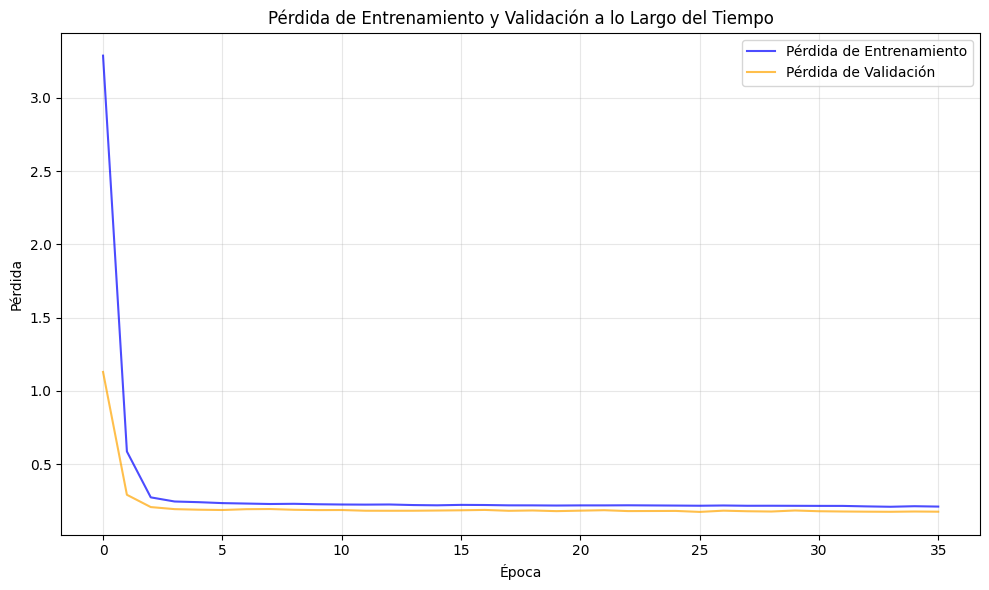


¡Entrenamiento completado con éxito! La mejor época fue: 26


In [28]:
print("Iniciando el entrenamiento del modelo de generación de música...")

torch.manual_seed(42)
np.random.seed(42)

# midi_dir_path = 'beeth'
# print(f"\nCargando archivos MIDI desde {midi_dir_path}...")
# all_music_data = load_all_midi_files(midi_dir_path)

if all_music_data is not None:
    print(f"Se cargaron con éxito {len(all_music_data)} eventos musicales")

    print("\nNormalizando los datos...")

    # Filtrar outliers
    filtered_music_data = filter_outliers(all_music_data, 1, 99)
    all_music_data_normalized = z_score_normalize_data_separately(filtered_music_data)

    train_data, val_data = split_data(all_music_data_normalized, validation_size=0.2, random_seed=42)

    print(f"Tamaño del conjunto de entrenamiento: {len(train_data)}")
    print(f"Tamaño del conjunto de validación: {len(val_data)}")

    config = get_config()

    print("\nInicializando el modelo...")
    model = MusicRNN(
        config['input_size'],
        config['hidden_size'],
        config['output_size'],
        config['num_layers'],
        config['dropout_p']
    )

    print("\nComenzando el entrenamiento...")
    losses, val_losses, best_epoch = train_model(model, train_data, val_data, config)

    print("\nGraficando los resultados del entrenamiento...")
    plot_losses(losses, val_losses)

    print(f"\n¡Entrenamiento completado con éxito! La mejor época fue: {best_epoch}")
else:
    print("No se pudieron cargar los archivos MIDI. Por favor, verifique la ruta del directorio.")

### Explicación de la Arquitectura del Modelo

**El modelo de red neuronal recurrente (MusicRNN)** 
El modelo es una red neuronal diseñada para la generación de música, empleando LSTM bidireccional, atención multicabeza y capas densas. Esta configuración ha sido elegida por su eficiencia dado el poder computacional disponible, aunque otras configuraciones podrían proporcionar mejores resultados.

1. **Input Features (Características de Entrada)**:
   - Recibe las características: `pitch`, `step`, `duration`, `velocity`.

2. **Bidirectional LSTM (LSTM Bidireccional)**:
   - 3 capas con tamaño oculto de 256 por dirección.
   - Captura dependencias en ambas direcciones para datos secuenciales.

3. **Multi-Head Attention (Atención Multicabezal)**:
   - 4 cabezas de atención.
   - Captura múltiples relaciones contextuales en la salida de LSTM.

4. **Layer Normalization (Normalización de Capa)**:
   - Estabiliza y mejora la capacidad de generalización.

5. **Fully Connected Layer (Capa Lineal 1)**:
   - Transforma la salida intermedia para preparación de activación.

6. **ReLU Activation**:
   - Introduce no linealidad para aprender funciones complejas.

7. **Dropout**:
   - 0.2 de probabilidad para prevenir sobreajuste.

8. **Fully Connected Layer (Capa Lineal 2)**:
   - Reduce la salida a 4 características: `pitch`, `step`, `duration`, `velocity`.

9. **Output Features (Características de Salida)**:
   - Predicciones de las próximas notas en términos de `pitch`, `step`, `duration`, y `velocity`.

Esta arquitectura ha sido adoptada debido a las restricciones de poder computacional, aunque se reconoce que hay potencial para configuraciones que podrían ofrecer un rendimiento aún mejor.


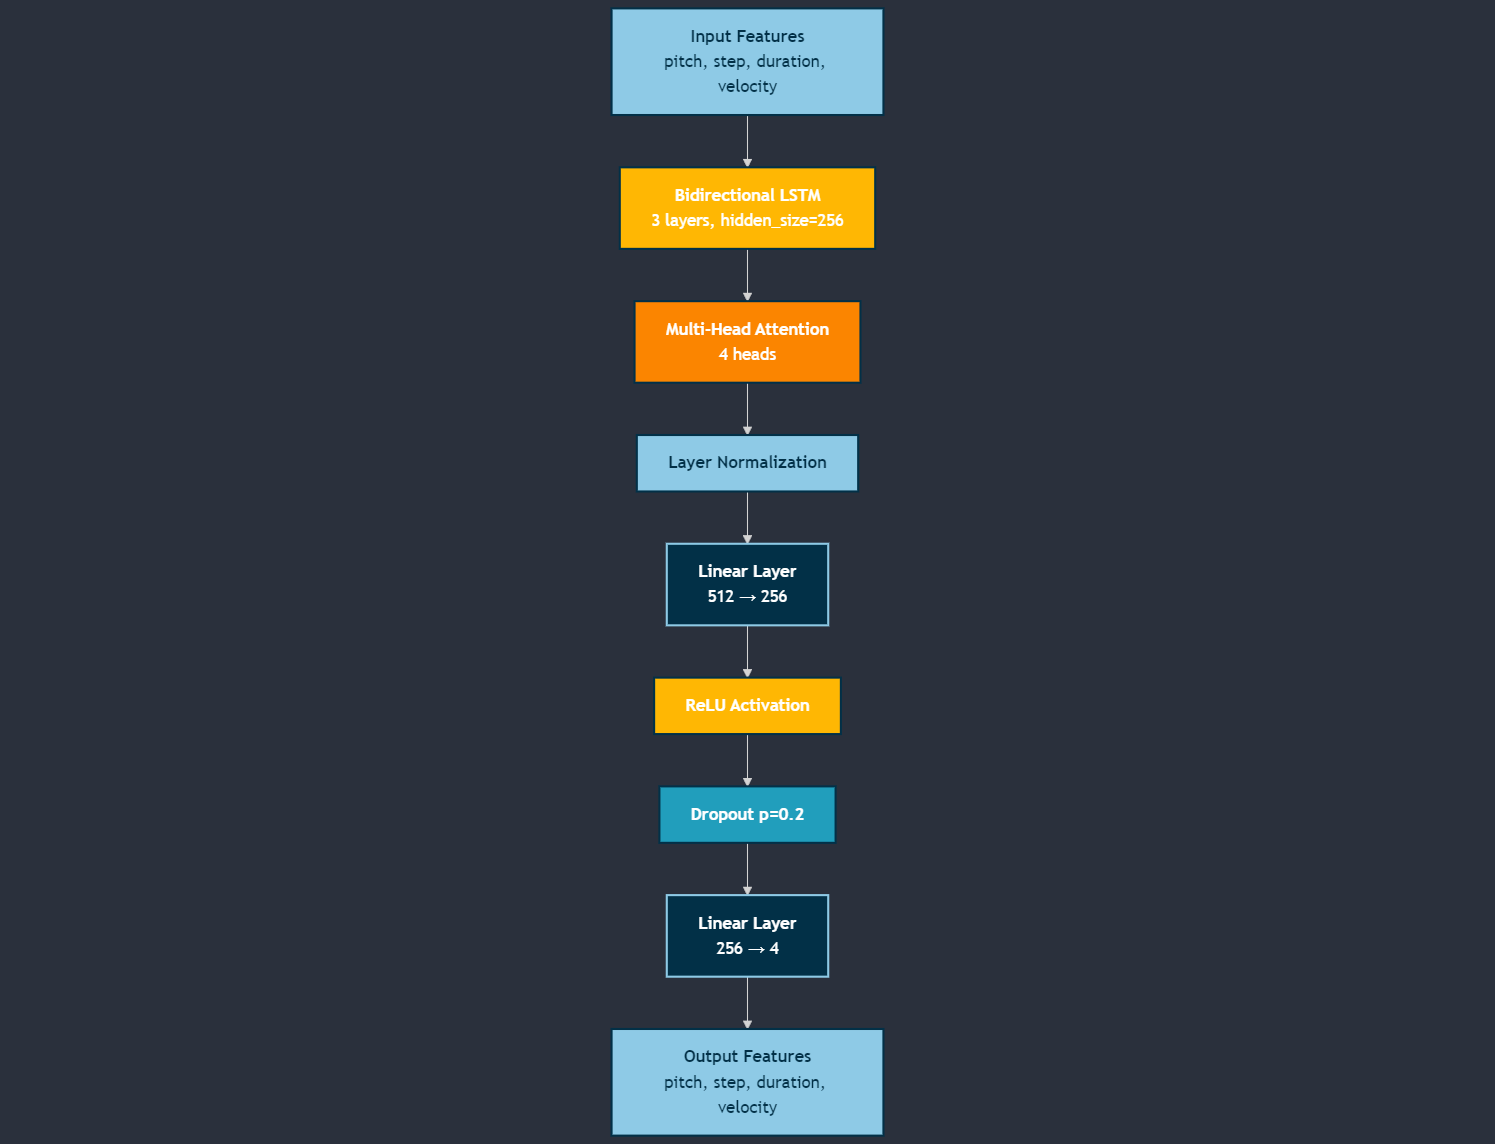

# Generar musica

In [41]:
def z_score_denormalize_data(normalized_data: np.ndarray, original_data: np.ndarray) -> np.ndarray:
    """
    Desnormaliza los datos normalizados por Z-Score.

    Args:
      normalized_data: Datos normalizados.
      original_data: Datos originales usados para calcular media y desviación estándar.

    Returns:
      Datos desnormalizados.
    """
    mean = original_data.mean(axis=0, keepdims=True)
    std = original_data.std(axis=0, keepdims=True)
    return normalized_data * std + mean

def initialize_sequence(data: np.ndarray, sequence_length: int) -> np.ndarray:
    """
    Inicializa una secuencia aleatoria de notas.

    Args:
      data: Datos de notas originales.
      sequence_length: Longitud de la secuencia a extraer.

    Returns:
      Una secuencia inicial de los datos.
    """
    start_idx = np.random.randint(0, len(data) - sequence_length)
    return data[start_idx:start_idx + sequence_length]

def generate_music(model, initial_sequence: np.ndarray, num_notes: int, device='cuda') -> np.ndarray:
    """
    Genera música a partir de una secuencia inicial usando un modelo entrenado.

    Args:
      model: Modelo de red neuronal entrenado para generación de música.
      initial_sequence: Secuencia inicial de notas.
      num_notes: Número de notas a generar.
      device: Dispositivo para computación ('cuda' o 'cpu').

    Returns:
      Una secuencia de notas generada por el modelo.
    """
    model.eval()
    generated_sequence = initial_sequence.tolist()

    current_sequence = torch.FloatTensor(initial_sequence).unsqueeze(0).to(device)
    hidden = model.init_hidden(1, device)

    with torch.no_grad():
        for _ in range(num_notes):
            output, hidden = model(current_sequence, hidden)
            next_note = output[:, -1].cpu().numpy().squeeze()
            generated_sequence.append(next_note)

            # Prepara la siguiente entrada
            next_input = torch.FloatTensor([next_note]).unsqueeze(0).to(device)
            current_sequence = torch.cat((current_sequence[:, 1:], next_input), dim=1)

    return np.array(generated_sequence)

def save_midi_file(notes: np.ndarray, file_name: str):
    """
    Guarda una secuencia de notas en un archivo MIDI.

    Args:
      notes: Secuencia de notas generadas.
      file_name: Nombre del archivo MIDI a guardar.

    Creates:
      Un archivo MIDI con las notas generadas.
    """
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)  # Instrumento acústico por defecto

    # Construcción de notas MIDI con las características dadas
    start_time = 0
    for note_features in notes:
        pitch, step, duration, velocity = note_features
        start_time += step  # Incrementa el tiempo de inicio con cada paso
        end_time = start_time + duration
        note = pretty_midi.Note(velocity=int(velocity), pitch=int(pitch), start=float(start_time), end=float(end_time))
        instrument.notes.append(note)

    midi.instruments.append(instrument)
    midi.write(file_name)

def clip_to_midi_range(notes: np.ndarray) -> np.ndarray:
    """
    Asegura que los valores de pitch y velocity estén dentro del rango MIDI.

    Args:
      notes: Array de notas generadas.

    Returns:
      Array de notas ajustado.
    """
    notes[:, 0] = np.clip(notes[:, 0], 0, 127)  # Clip de pitch
    notes[:, 3] = np.clip(notes[:, 3], 0, 127)  # Clip de velocity
    return notes

def adjust_timing(notes: np.ndarray, step_scale: float = 0.4, duration_scale: float = 1) -> np.ndarray:
    """
    Ajusta los pasos y duraciones para que las notas no estén tan separadas.

    Args:
      notes: Array de notas generadas.
      step_scale: Factor de escala para step.
      duration_scale: Factor de escala para duration.

    Returns:
      Array de notas ajustado con tiempos escales.
    """
    notes[:, 1] *= step_scale  # Ajustar step
    notes[:, 2] *= duration_scale  # Ajustar duration
    return notes


# Cargar el modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MusicRNN(
        config['input_size'],
        config['hidden_size'],
        config['output_size'],
        config['num_layers'],
        config['dropout_p'])
model.load_state_dict(torch.load('best_music_model.pth', map_location=device))
model.to(device)

# Generar y guardar canciones
num_songs = 3
notes_per_song = 200
sequence_length = 32  # Configurado para pruebas rápidas

# Generar y guardar canciones
for i in range(num_songs):
    initial_seq = initialize_sequence(filtered_music_data, sequence_length)
    generated_notes_normalized = generate_music(model, initial_seq, notes_per_song, device=device)
    generated_notes = z_score_denormalize_data(generated_notes_normalized, all_music_data)
    clipped_notes = clip_to_midi_range(generated_notes)
    adjusted_notes = adjust_timing(clipped_notes)  # Ajustar timings
    save_midi_file(adjusted_notes, f'generated_song_{i+1}.mid')
    print(f"Canción generada guardada como 'generated_song_{i+1}.mid'")


<ipython-input-41-cada0fe380f5>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_music_model.pth', map_location=device))


Canción generada guardada como 'generated_song_1.mid'
Canción generada guardada como 'generated_song_2.mid'
Canción generada guardada como 'generated_song_3.mid'
